# Time-Lagged Autoencoders

## TODO: read paper again, whitening should be done **independently** for both series, there are some werid things on mean and std as well

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input, Dense, Dropout
from keras.callbacks import ModelCheckpoint, TensorBoard

from sklearn.cluster import KMeans

Using TensorFlow backend.


## Load and prepare data

In [2]:
with np.load('./data/dimredux-challenge-01-data.npz') as npz:
    data_x = npz['data_x']
    state_validation_x = npz['validation_x']
    state_validation_y = npz['validation_y']
    
data_x.shape

(100000, 3)

### Whiten

In [3]:
mean = np.mean(data_x, axis=0)
std = np.std(data_x, axis=0)

def whiten(data):
    return (data - mean) / std

data_x = whiten(data_x)
state_validation_x = whiten(state_validation_x)

### Define time lagging

In [4]:
tau = 200

def time_lagg_split(x):
    return x[:-tau], x[tau:]

train_x, train_y = time_lagg_split(data_x)
validation_x, validation_y = time_lagg_split(state_validation_x)

print(train_x.shape)
print(train_y.shape)
print(validation_x.shape)
print(validation_y.shape)

(99800, 3)
(99800, 3)
(800, 3)
(800, 3)


In [5]:
labels_count = 4

### Visualize data (points coloured by labels)

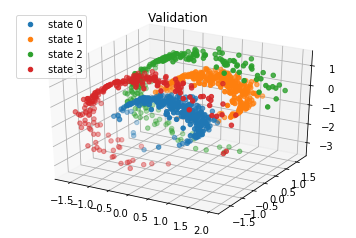

In [6]:
%matplotlib inline

fig = plt.figure()
ax = fig.gca(projection='3d')

for y in range(labels_count):
    data = state_validation_x[state_validation_y == y, :]
    ax.scatter(data[:, 0], data[:, 1], data[:, 2], label="state "+str(y))
    
plt.legend()
plt.title('Validation')
plt.show()

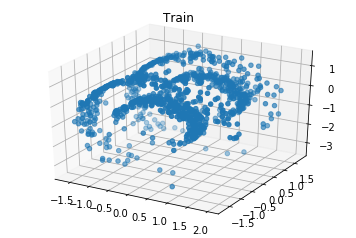

In [7]:
%matplotlib inline

fig = plt.figure()
ax = fig.gca(projection='3d')

points = data_x[::100]

ax.scatter(points[:, 0], points[:, 1], points[:, 2])
    
plt.title('Train')
plt.show()

### Check time series

If the distance is too big, there is basically no way of building a solid model out of that

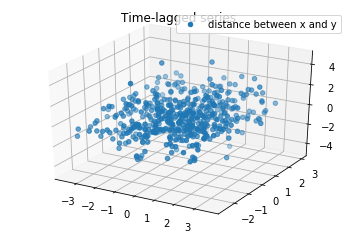

In [8]:
%matplotlib inline

fig = plt.figure()
ax = fig.gca(projection='3d')

points = (train_x - train_y)[::200]

ax.scatter(points[:, 0], points[:, 1], points[:, 2], label="distance between x and y")
    
plt.title('Time-lagged series')
plt.legend()
plt.show()

## Define Model

In [9]:
input_dim = train_x.shape[1]
input_shape = (input_dim, )
target_dim = 1

hidden_layers = [200, 100]
batch_size = 256
epochs = 10

### Encoder

In [10]:
encoder_input = Input(shape=input_shape, name='encoder_input')
x = encoder_input
for layer in hidden_layers:
    x = Dense(layer, activation='relu')(x)
    x = Dropout(0.5)(x)
    
x = Dense(target_dim, activation='relu', name='encoder_output')(x)
encoder = Model(encoder_input, x, name='encoder')
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 3)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               800       
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               20100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
encoder_output (Dense)       (None, 1)                 101       
Total params: 21,001
Trainable params: 21,001
Non-trainable params: 0
_________________________________________________________________


### Decoder

In [11]:
decoder_input = Input(shape=(target_dim, ), name='decoder_input')
x = decoder_input
for layer in hidden_layers[::-1]:
    x = Dense(layer, activation='relu')(x)
    x = Dropout(0.5)(x)
    
x = Dense(input_dim, name='decoder-output', activation='relu')(x)
decoder = Model(decoder_input, x, name='decoder')
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   (None, 1)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               200       
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 200)               20200     
_________________________________________________________________
dropout_4 (Dropout)          (None, 200)               0         
_________________________________________________________________
decoder-output (Dense)       (None, 3)                 603       
Total params: 21,003
Trainable params: 21,003
Non-trainable params: 0
_________________________________________________________________


### Autoencoder

In [12]:
auto_encoder_out = decoder(encoder(encoder_input))

auto_encoder = Model(encoder_input, auto_encoder_out, name='autoencoder')
auto_encoder.summary()
auto_encoder.compile(loss='mse', optimizer='adadelta')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 3)                 0         
_________________________________________________________________
encoder (Model)              (None, 1)                 21001     
_________________________________________________________________
decoder (Model)              (None, 3)                 21003     
Total params: 42,004
Trainable params: 42,004
Non-trainable params: 0
_________________________________________________________________


## Fit Model

In [13]:
checkpointer = ModelCheckpoint(filepath='./model/weights.hdf5', verbose=1, save_best_only=True)
tensorboard = TensorBoard(log_dir='./stats/dim_reduction') 
history = auto_encoder.fit(train_x, train_y,
                batch_size=batch_size,
                epochs=epochs,
                verbose=1,
                shuffle=True,
                validation_data=(validation_x, validation_y),
                callbacks=[checkpointer, tensorboard])

Train on 99800 samples, validate on 800 samples
Epoch 1/10
99800/99800 [==============================] - 3s 29us/step - loss: 0.9997 - val_loss: 0.9599

Epoch 00001: val_loss improved from inf to 0.95991, saving model to ./model/weights.hdf5
Epoch 2/10
99800/99800 [==============================] - 3s 27us/step - loss: 0.9997 - val_loss: 0.9599

Epoch 00002: val_loss did not improve from 0.95991
Epoch 3/10
99800/99800 [==============================] - 3s 29us/step - loss: 0.9997 - val_loss: 0.9599

Epoch 00003: val_loss did not improve from 0.95991
Epoch 4/10
99800/99800 [==============================] - 3s 27us/step - loss: 0.9997 - val_loss: 0.9599

Epoch 00004: val_loss did not improve from 0.95991
Epoch 5/10
99800/99800 [==============================] - 3s 27us/step - loss: 0.9997 - val_loss: 0.9599

Epoch 00005: val_loss did not improve from 0.95991
Epoch 6/10
99800/99800 [==============================] - 3s 27us/step - loss: 0.9997 - val_loss: 0.9599

Epoch 00006: val_loss d

## Get best weights

In [14]:
auto_encoder.load_weights("./model/weights.hdf5")

## Define prediction, use kmeans on reduced dataset

### Prediction, kmeans

In [15]:
def predict(X):
    reduced = encoder.predict(X)
    kmeans = KMeans(n_clusters=labels_count, random_state=0)
    
    return kmeans.fit_predict(X)

### Evaluation

In [16]:
from itertools import permutations

def evaluate(X, y):
    y_prediction = predict(X)
    
    prediction_permutations = []
    best = 0
    sums = 0
    
    labels = list(range(labels_count))
    for perm in permutations(labels):
        perm_i = np.copy(y_prediction)
        
        for i, label in enumerate(perm):
            perm_i[np.where(y_prediction == i)] = label
        prediction_permutations.append(perm_i)
                
    for prediction in prediction_permutations:
        correct = len((np.where(prediction == y))[0])
        score = 100. * correct / len(y)
        sums += score
        
        if score > best:
            best = score
    
    return best 

In [17]:
print('Accuracy: {:.2f}%'.format(evaluate(state_validation_x, state_validation_y)))

Accuracy: 69.20%


## Visualize results

### See labels in original space

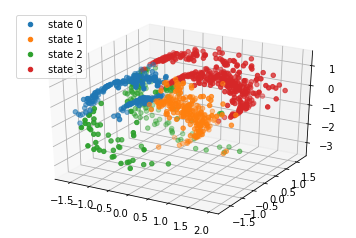

In [25]:
%matplotlib inline
prediction = predict(state_validation_x)

fig = plt.figure()
ax = fig.gca(projection='3d')

for y in range(labels_count):
    data = state_validation_x[prediction == y, :]
    ax.scatter(data[:, 0], data[:, 1], data[:, 2], label="state "+str(y))
    
plt.legend()
plt.show()

### See mapped space

Here we expect to see some clear space between the clusters

On the y axes we see the data, on the x-axis the labels are mapped. The second is done just to prevent overlapping so we can see better how linearly separable the data is.

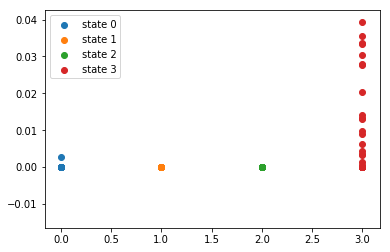

In [19]:
projection = encoder.predict(state_validation_x)

fig = plt.figure()
ax = fig.add_subplot(111)

for y in range(labels_count):
    data = projection[state_validation_y == y, :]
    ax.scatter(np.ones(len(data)) * y, data[:, 0], label="state " + str(y))
    
plt.legend()
plt.show()

### See reconstructed space

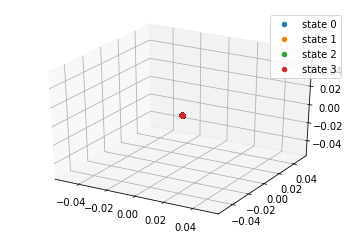

In [20]:
reconstructed = decoder.predict(projection)

fig = plt.figure()
ax = fig.gca(projection='3d')

for y in range(labels_count):
    data = reconstructed[state_validation_y == y, :]
    ax.scatter(data[:, 0], data[:, 1], data[:, 2], label="state " + str(y))
    
plt.legend()
plt.show()